## Automated Stock Trading

In [133]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

## Logging Setup
import sys
# sys.stdout = open("Investment_Logs.txt", "w")

## Enabling R Interaction
# %load_ext rpy2.ipython

In [134]:
## API Library Setup
import os

## Robinhood API Setup
import robin_stocks as rs
# Connecting to RobinHood
# rs.login(
#     username = os.getenv("RH_LOGIN"),
#     password = os.getenv("RH_PASS"),
#     expiresIn = 3600*24*7,
#     by_sms = True
# )

## Alpaca API Setup
import alpaca_trade_api as tradeapi
# Connecting to Alpaca
api = tradeapi.REST(os.getenv("AP_KEY"),os.getenv("AP_SECRET"), api_version='v2')
apip = tradeapi.REST(os.getenv("APP_KEY"),os.getenv("APP_SECRET"), api_version='v2',base_url='https://paper-api.alpaca.markets')

In [135]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
min_investment = 15


## Account ## (rh = Robin hood, ap = Alpaca Live, app = Alpaca Paper)
Account = "app"

In [136]:
## Installing Required Packages
import sys
from time import sleep
import math
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from scipy import stats
from sklearn import tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

max_investment = Get_Equity(Account)*0.2
max_investment

API_Helpers.py
Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


18976.84

### Historical Data Pull

In [137]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]
Final_Assets.extend(['TQQQ','SQQQ'])

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
Final_Stocks.extend(['TQQQ','SQQQ'])
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    if i in ['TQQQ','SQQQ']:
        TMP['sector'] = 'Leveraged Market'
        TMP['industry'] = 'Leveraged Market'
    else:
        TMP['sector'] = Company_Data[i].sector
        TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]
## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume



Pulling Company Data



Formatting Final Dataset


In [138]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
# Combined_Data.to_csv(Project_Folder + "Data//Historical_Data_Stocks.csv")

### Exploring Total Market Performance
Combined_Data = Combined_Data.drop_duplicates()
if datetime.now().hour < 19:
    Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):(datetime.now()- timedelta(days = 1)).strftime("%Y-%m-%d")]
else:
    Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]

## Run to Update Total Market Data
# Total_Market.to_csv(Project_Folder + "Data//Historical_Data_Total.csv")

Total_Market.tail(10)

,close,high,low,open,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD,AD,Running_Up,Running_Down
date,,,,,,,,,,,,,,,
2020-10-19 00:00:00-04:00,90.753052,93.178563,90.248639,92.257846,2.917966e+06,1146.0,-0.011495,-0.019491,-0.088581,91.740607,67.176601,0.283465,-0.622221,0,2
2020-10-20 00:00:00-04:00,91.077765,92.611592,90.314011,91.302572,3.107302e+06,1146.0,0.003578,-0.013676,0.064886,91.488028,61.523425,0.183683,-0.338701,1,0
2020-10-21 00:00:00-04:00,90.487597,92.325169,89.744437,91.118297,2.838198e+06,1146.0,-0.006480,-0.014757,-0.086604,91.216956,61.169766,0.065615,-0.391428,0,1
2020-10-22 00:00:00-04:00,91.054182,92.055491,89.336942,90.572671,3.507982e+06,1146.0,0.006261,-0.009829,0.235989,91.036190,61.014045,0.015947,0.300443,1,0
2020-10-23 00:00:00-04:00,91.647936,92.436841,90.253511,91.498365,3.050523e+06,1146.0,0.006521,-0.001747,-0.130405,91.004106,60.216301,0.013452,0.275140,2,0
2020-10-26 00:00:00-04:00,89.928436,91.593555,88.615769,90.695448,3.447941e+06,1146.0,-0.018762,-0.009086,0.130279,90.839183,55.631187,-0.107002,-0.132720,0,1
2020-10-27 00:00:00-04:00,89.296942,90.919211,88.451454,89.868921,3.414622e+06,1146.0,-0.007022,-0.019553,-0.009663,90.483019,50.192002,-0.225398,-0.349551,0,2
2020-10-28 00:00:00-04:00,86.553198,88.757052,85.791387,87.665367,4.263967e+06,1146.0,-0.030726,-0.043480,0.248738,89.696139,44.989296,-0.470583,-0.674281,0,3
2020-10-29 00:00:00-04:00,87.260149,88.719265,85.390914,86.706314,3.965619e+06,1146.0,0.008168,-0.041668,-0.069970,88.937332,35.558026,-0.561097,0.158915,1,0


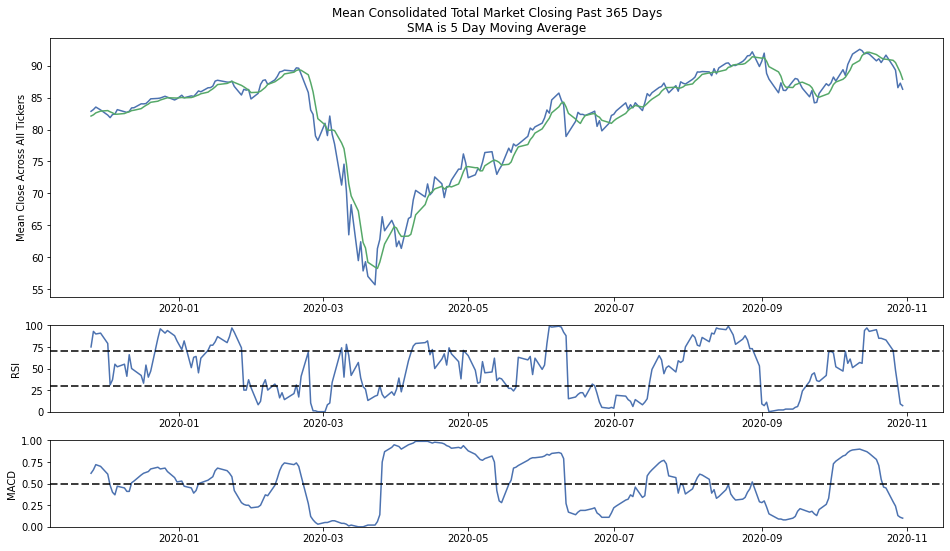

In [139]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

In [172]:
Model_Data = Total_Market.loc[:,['RSI','MACD','AD','Running_Up','Running_Down','close_diff']]


X = Model_Data. \
    query('RSI > 0')
y = list(X.Running_Up.shift(-1) > 0)

TQQQ_Data = Combined_Data.query('stock == "TQQQ"')
TQQQ_Change = (TQQQ_Data.open.shift(-1) - TQQQ_Data.close.shift(-1))/TQQQ_Data.close.shift(-1)
TQQQ_Change = TQQQ_Change.tail(len(y))
SQQQ_Data = Combined_Data.query('stock == "SQQQ"')
SQQQ_Change = (SQQQ_Data.open.shift(-1) - SQQQ_Data.close.shift(-1))/SQQQ_Data.close.shift(-1)
SQQQ_Change = SQQQ_Change.tail(len(y))           

learning = 10

X_ini = X.head(learning)
y_ini = y[0:learning]

gnb = GaussianNB()
fit = gnb.fit(X_ini,y_ini)
print("\nClass Probability Order\n",fit.classes_)
print("\nTest Set Accuracy\n",fit.score(X_test,y_test))

ret = 1
pct = 0.80

print("\nCumulative Returns @ Learning Period of",learning,"\n")
for i in range(learning+2,len(y)):
    fit = gnb.partial_fit(X.iloc[[i-1]],[y[i-1]])
    prob = fit.predict_proba(X.iloc[[i]])
    if prob[0][0] > pct:
        mult = 1 + SQQQ_Change[i]
    elif prob[0][1] > pct:
        mult = 1 + TQQQ_Change[i]
    else:
        mult = 1
    mult =  1 + (prob[0][0]*SQQQ_Change[i] + prob[0][1]*TQQQ_Change[i])  
    ret = ret * mult
    print(ret)

Next_Day_Prob = prob[0]


Class Probability Order
 [False  True]

Test Set Accuracy
 0.5

Cumulative Returns @ Learning Period of 10 

1.0024300546796558
1.000886880238373
1.0009634164585792
1.0004446450810247
1.0007125222121158
0.9808428070842365
0.9892656678242261
0.9752994650850532
0.9853583556181876
0.9801996518450079
0.9885723055695717
1.0277725165900817
1.0291037332848318
1.009136312395961
1.008578704046738
1.0259992207667794
1.0124810861063251
1.0199203343511565
1.0199295290211516
1.024988182564635
1.0244280258945266
1.019658525023468
1.0223848795924608
1.0269891674000227
1.0187958380761
1.0180665549703078
1.0448876933564537
1.0549936309071193
1.0853165195958416
1.0382142067676938
1.0096561255469159
1.0159533676628068
1.026202042017727
1.0436463561259852
1.04335316751651
1.005144138986579
1.016463446484931
1.0112910216268494
0.9985803023421002
0.9976162965440745
0.9875667830473996
0.9816033510796974
0.9866672661591194
0.9968119560248793
1.001741758036952
1.0707923057072997
1.0724608663573527
1.160759966

In [164]:
TQQQ_Weight = Next_Day_Prob[1]
SQQQ_Weight = Next_Day_Prob[0]
print("Bull %:",np.round(TQQQ_Weight,2))

Bull %: 0.67


## Digging Into A Sector Ranking

In [173]:
Sectors = list(Combined_Data['sector'].unique())
Total_Sector_Summary = Group_Consolidator(
    Combined_Data = Combined_Data,
    groups = Sectors,
    column = 'sector'
)
Sector_Data = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    q = 0.20
)
if len(Sector_Data) == 0:
    Sector_Data = list()
    print("No Viable Sectors Currently")

In [174]:
Sector_Summary = Sector_Data. \
        drop(['last_period_return','last_price','mu_day_up','sd_day_up','mu_day_down','sd_day_down'],axis = 1)
Sector_Summary

,quant_day_up,quant_day_down,sd_ret,sd_loss,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
sector,,,,,,,,,,,,
Leveraged Market,0.008538,-0.010210,0.018265,0.022995,0.794303,-0.008412,44.448583,-1.246578,0.012168,0.38,3.015925,0.00
Energy,0.006435,-0.014007,0.013146,0.013724,0.957884,-0.004998,34.737588,-0.088426,0.007927,0.25,1.820793,0.00
Basic Materials,0.004127,-0.005652,0.007521,0.010476,0.717927,-0.003467,30.099444,-0.438086,0.007662,0.07,1.330295,0.00
Communication Services,0.005788,-0.007226,0.005472,0.008117,0.674141,-0.003966,38.388069,-0.511823,0.005423,0.40,0.767681,0.04
Technology,0.010813,-0.006622,0.007485,0.010629,0.704205,-0.003508,34.573438,-0.871811,0.005216,0.14,1.353287,0.00
Real Estate,0.005069,-0.010940,0.008157,0.008786,0.928409,-0.005817,23.165162,-0.459276,0.000005,1.00,0.870220,0.00
Financial Services,0.006936,-0.007185,0.005376,0.007782,0.690825,-0.003138,34.259835,-0.442361,-0.000366,0.95,0.935708,0.00
Healthcare,0.009472,-0.009189,0.009311,0.007501,1.241301,-0.004026,38.760294,-0.678870,-0.001261,0.79,0.748427,0.01
Industrials,0.005006,-0.005158,0.005581,0.008745,0.638193,-0.003816,26.102431,-0.776710,-0.001727,0.77,0.977941,0.00


## Diving Further Into Individual Idustries

In [26]:
if type(Sector_Summary) is not list:
    Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
    Industries = list(Top_Sector['industry'].unique())
    Industry_Data = Group_Consolidator(Combined_Data = Top_Sector,
                                          groups = Industries,
                                          column = 'industry',
                                          q = 0.20
                                         )
else:
    print("No sectors to loop through")
    Industry_Data = list()
    

In [28]:
Industry_Summary = Industry_Data. \
    drop(['mu_day_up','sd_day_up','mu_day_down','sd_day_down'],axis = 1). \
    query('quant_day_up > 0 & quant_day_down < 0')
Industry_Summary

,last_period_return,last_price,quant_day_up,quant_day_down,sd_ret,sd_loss,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
industry,,,,,,,,,,,,,,
Real Estate Services,-0.046586,76.030000,0.009405,-0.004992,0.014872,0.012058,1.233372,-0.005308,42.366345,-0.914999,0.017963,0.13,2.276842,0.00
Oil & Gas - Refining & Marketing,-0.060528,26.169000,0.001102,-0.021673,0.012123,0.018026,0.672529,-0.006661,45.331743,-0.159227,0.017832,0.14,2.502843,0.00
Steel,-0.029970,52.231250,0.004088,-0.005018,0.010204,0.016423,0.621324,-0.002065,39.281983,-0.326754,0.013111,0.04,1.600839,0.00
Building Materials,-0.042149,64.487667,0.002045,-0.006783,0.012296,0.017432,0.705369,-0.004995,26.163828,-0.520689,0.012975,0.02,1.797568,0.00
Leveraged Market,-0.116530,71.132600,0.008538,-0.009812,0.018265,0.022995,0.794303,-0.008412,44.448583,-1.246562,0.012118,0.38,3.015519,0.00
Oil & Gas - Services,-0.066536,11.883000,0.003166,-0.006303,0.013981,0.017931,0.779711,-0.005098,33.466510,0.006707,0.010083,0.58,1.958745,0.06
Semiconductors,-0.042289,111.036605,0.000626,-0.009637,0.012366,0.009171,1.348381,-0.003988,41.628783,-1.064016,0.009714,0.13,1.529940,0.00
Oil & Gas - Drilling,-0.049233,14.870000,0.001729,-0.002564,0.019486,0.020815,0.936152,-0.000281,34.588702,0.038519,0.009279,0.65,1.588078,0.17
Engineering & Construction,-0.038248,39.635000,0.009748,-0.005498,0.010495,0.013724,0.764719,0.000125,41.754037,-0.236742,0.009079,0.33,1.404805,0.01


## Diving Into The Individual Stocks

In [29]:
if type(Industry_Summary) is not list:
    Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
#     Stocks = list(Top_Industry['stock'].unique())
    Stocks = ['SQQQ','TQQQ']
    Stock_Data = Group_Consolidator(Combined_Data = Top_Industry,
                                       groups = Stocks,
                                       column = 'stock',
                                       q = 0.20
    )
else:
    print("No industries to loop through")
    Stock_Data = list()

In [32]:
Stock_Summary = Stock_Data. \
    drop(['mu_day_up','sd_day_up','mu_day_down','sd_day_down'],axis = 1). \
    query('quant_day_up > 0 & quant_day_down < 0')

Stock_Summary

,last_period_return,last_price,quant_day_up,quant_day_down,sd_ret,sd_loss,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
stock,,,,,,,,,,,,,,
TQQQ,-0.159291,117.2200,0.000842,-0.006489,0.026466,0.032908,0.804242,-0.011235,45.044424,-2.850135,0.018425,0.36,4.280769,0.0
SQQQ,0.159500,25.0452,0.006794,-0.001173,0.032892,0.026362,1.247705,0.011012,51.803725,0.357011,-0.018865,0.35,-4.288054,0.0


In [88]:
Long = Combined_Data.query('stock == "TQQQ"')
Running_Up = [0]
Running_Down = [0]
for i in range(1,len(Long.close)):
    if Long.close[i] - Long.close[i-1] > 0:
        Running_Up.append(Running_Up[i-1] + 1)
        Running_Down.append(0)
    else:
        Running_Down.append(Running_Down[i-1] + 1)
        Running_Up.append(0)
Long = Long. \
    assign(Running_Up = Running_Up,
           Running_Down = Running_Down)
Up_Percent = Long.groupby('Running_Up')['date'].nunique()/len(Long.close)*100
Down_Percent = Long.groupby('Running_Down')['date'].nunique()/len(Long.close)*100
print(Down_Percent)
print(Up_Percent)
Long

Running_Down
0    63.241107
1    26.086957
2     6.719368
3     2.766798
4     0.790514
5     0.395257
Name: date, dtype: float64
Running_Up
0     37.154150
1     26.086957
2     16.205534
3      9.090909
4      5.533597
5      2.371542
6      1.185771
7      0.790514
8      0.395257
9      0.395257
10     0.395257
11     0.395257
Name: date, dtype: float64


,stock,open,high,low,close,volume,date,sector,industry,Running_Up,Running_Down
2019-10-31 00:00:00-04:00,TQQQ,69.77,69.9200,68.1100,69.29,14716944,2019-10-31 00:00:00-04:00,Leveraged Market,Leveraged Market,0,0
2019-11-01 00:00:00-04:00,TQQQ,70.22,71.1900,69.8850,71.18,13783662,2019-11-01 00:00:00-04:00,Leveraged Market,Leveraged Market,1,0
2019-11-04 00:00:00-05:00,TQQQ,72.61,72.9700,72.1200,72.45,11649264,2019-11-04 00:00:00-05:00,Leveraged Market,Leveraged Market,2,0
2019-11-05 00:00:00-05:00,TQQQ,72.77,72.9800,71.8900,72.49,12405913,2019-11-05 00:00:00-05:00,Leveraged Market,Leveraged Market,3,0
2019-11-06 00:00:00-05:00,TQQQ,72.35,72.3828,71.0500,72.11,14026056,2019-11-06 00:00:00-05:00,Leveraged Market,Leveraged Market,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26 00:00:00-04:00,TQQQ,135.77,139.9800,127.4900,132.85,38114060,2020-10-26 00:00:00-04:00,Leveraged Market,Leveraged Market,0,1
2020-10-27 00:00:00-04:00,TQQQ,134.27,137.2000,132.5200,135.90,25606761,2020-10-27 00:00:00-04:00,Leveraged Market,Leveraged Market,1,0
2020-10-28 00:00:00-04:00,TQQQ,129.42,130.2400,119.8002,120.19,42997615,2020-10-28 00:00:00-04:00,Leveraged Market,Leveraged Market,0,1
2020-10-29 00:00:00-04:00,TQQQ,121.97,130.4600,121.2400,126.19,31317295,2020-10-29 00:00:00-04:00,Leveraged Market,Leveraged Market,1,0


<AxesSubplot:ylabel='Frequency'>

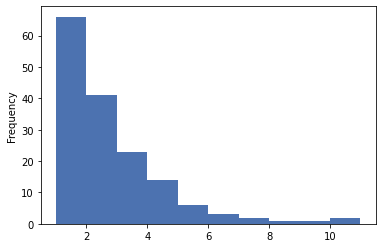

In [33]:
## Pulling Current Stock Holdings
Current_Holdings = Get_Holdings(Account)
Current_Holdings = []

## Combining Lists
if isinstance(Current_Holdings,pd.DataFrame):
    if Current_Holdings.empty:
        Stocks = []
    else:
        Stocks = list(Current_Holdings.keys())
else:
    if not Current_Holdings:
        Stocks = []
    else:
        Stocks = [i.symbol for i in Current_Holdings]
        
if len(Stock_Summary) != 0:
    Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

## Pulling Historical Data
Hist_Data = pd.DataFrame()
for Stock in Stocks:
    Hist_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock].tail(OLS_Window*5)

Market_Data = pd.DataFrame({'mkt':Total_Market.loc[:,'close'].tail(OLS_Window*5)})

## Creating expected mean and variance matricies
mu = expected_returns.capm_return(Hist_Data,Market_Data)
S = risk_models.exp_cov(Hist_Data) #Get the sample covariance matrix

## Optimizing Sharpe Ratio
ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (-0.2,0.2),
    verbose = False
)
# weights = ef.max_sharpe()
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights(cutoff = 0.01) 

## Subsetting Stock Picks
Final_Picks = []
for stock in cleaned_weights.keys():
    if cleaned_weights[stock] != 0:
        print(stock," : ",cleaned_weights[stock])
        Final_Picks.append(stock)
        
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

OptimizationError: Please check your objectives/constraints or use a different solver.

In [35]:
S

,SQQQ,TQQQ
SQQQ,0.616379,-0.616657
TQQQ,-0.616657,0.616982


## Robinhood Automated Investing POC

In [136]:
## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
## Quantile for Deciding Limit Orders
q = 0.20
## Quantile for Deciding Stop Loss / Take Profit Orders
qsp = 0.80

## Pulling Relevent Account Information
Account_Equity = Get_Equity(Account)

## Pulling Open Orders
Open_Orders = Get_Open_Orders(Account)

## Pulling Current Stock Holdings
Current_Holdings = Get_Holdings(Account)

## Checking Portfolio Balancing And Placing New Orders
for s in Final_Picks:

    # Optimal Portfolio Percentage
    Rcm_Holding = cleaned_weights[s]*100
    
    # Portfolio Restructuring
    if s in list(Current_Holdings.keys()):
        
        # Current Portfolio Percentage
        Pct_Holding = np.round(float(Current_Holdings[s].equity)*100/Account_Equity,2)
        Pct_Return = float(Current_Holdings[s]['percent_change'])

        # Rebalancing If Beyond Recommended Holding
        if Pct_Holding > Rcm_Holding*1.05:
            Rebalance_Lower(s,q,Account)
            
        # Checking If More Needs Purchased
        elif Pct_Holding < Rcm_Holding*0.95:
            Rebalance_Higher(s,q,Account)
            
        # Make No Changes    
        else:
            print("\n",s," Within Recommended Percentage")
            Exit_Orders(s,q = qsp,Account = Account)        
     
    ## Stocks Not Currently Held
    else:
        Open_Position(
            s = s,
            Rcm_Holding = Rcm_Holding,
            q = q,
            Account = Account)
        
## Closing Required Positions
if Current_Holdings.empty:
     print("\nNo positions to close, none are held")
else:
    for s in [s for s in list(Current_Holdings.keys()) if s not in Final_Picks]:
        Close_Position(s,Account)

API_Helpers.py
Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


Rebalancing RARE : Currently = -5.07 , Target = -4.968

Can Only Rebalance In Whole Share Amounts


Rebalancing PLCE : Currently = -2.14 , Target = -2.183

Can Only Rebalance In Whole Share Amounts


Rebalancing KURA : Currently = -4.39 , Target = -4.61

Can Only Rebalance In Whole Share Amounts


Rebalancing VCYT : Currently = 12.99 , Target = 13.699

Buying  19.0

Order ID: d064044a-0e2b-4bf2-a692-aabacbf8df0d placed

 DOV  Within Recommended Percentage

Setting Take Profit For DOV At: 112.72

Order ID: 9b99f7e5-e28f-4180-ae6d-1d69b5ecfc38 placed

Canceling Existing Order: 1b616d26-e294-4a4e-89b1-310d5ed8837c


Opening ZGNX Position

Order ID: 86d2f603-287a-47bd-a0bb-dcbb28a0915e placed


Rebalancing CSIQ : Currently = 1.15 , Target = 1.216

Buying  1.0

Order ID: fe9f6b1a-d79e-4c0e-b737-a74b25c407c8 placed

Canceling Existing Order: a1ae31da-3418-4078-9a89-b87eddd9ea9d


Opening PII Position

Order 